# New bussines location indicator

### Coursera project capstone

This is the course captstone project for the coursera IBM machine learning specialization

### About the project

Having a good location for your business is an important factor for it's prosperity. although the hot spots in a city for a new venue are common knowledge, usually this places have a very high price given that this knowledge is correlated with higher demand. With some datamining and machine learning, some places cam be discovered as good opportunity’s that does not yet received peoples attention.

This project uses python, foursquare api, machine learning and visualization tools to give some insight on where you should open your business in a city.
It works by ranking the places in city by how hot they are for business and them finding what is the optimal place for a new business that does not collide with other similar business by location but also is on a "hot spot" in the city.

The data will on the amount of venues by location will be collected using the foursquare api for a given city. The app/notebook will be created in a generic way so that people using it can change the city name. 
A map of the city based on the amount of venues will be created and also another one for the similar venues as the person is looking to create.

A score for a given location that will be created by adding value for number of venues using mahalanobis distance as a weight and the using the opposite (decreasing score) by having similar venues.
In the and, points will be clustered together to have useful locations as a suggestion for the new business to open.

### Let's start by importing the libraries we will need

In [157]:
import pandas as pd
import numpy as np
import folium, requests, os, time, itertools
import folium.plugins as plugins
from bs4 import BeautifulSoup
from urllib.request import urlopen
from geopy.geocoders import Nominatim

## Defining the place of interest and search area

In [139]:
# this will be our center point in the city
lat_city_center, lng_city_center = -22.727482, -47.648811

# now, create a map with this lat and lng info
map_city = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
folium.CircleMarker(
        [lat_city_center, lng_city_center],
        radius=10,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  

In [140]:
# check if it is correct
#map_city

In [141]:
# Defining the search grid size and location

In [142]:
number_x_points = 10
number_y_points = 10

lat_city_center, lng_city_center = -22.727482, -47.648811
# the farthest point of interest in the map
x_max, y_max =  -22.713566, -47.659758

# now we create a distance range in lat and lng distance measure
lat_delta = 2*np.abs(x_max - lat_city_center)
lng_delta = 2*np.abs(y_max - lng_city_center)

In [143]:
# create the matrix of points for use in the map and foursquare
lat_range = np.linspace(lat_city_center - lat_delta, lat_city_center + lat_delta, number_x_points)
lng_range = np.linspace(lng_city_center - lng_delta, lng_city_center + lng_delta, number_y_points)

In [144]:
lat_range

array([-22.755314  , -22.74912911, -22.74294422, -22.73675933,
       -22.73057444, -22.72438956, -22.71820467, -22.71201978,
       -22.70583489, -22.69965   ])

In [145]:
for lat in lat_range:
    for lng in lng_range:
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)
map_city

whe can see that we have covered most of the city with every point at around 200m from each other

## Requesting the data from the location with foursquare api

In [113]:
# Client ID and cliet secret key shoud never be stored in the notebook or other script,
# so we read it from os enviroment variable. 

CLIENT_ID = 'OHYNR0DTJAZBPYS2YKPXKPVY5YTP1I1HAKEY5S4BZBP0CVBF' 
CLIENT_SECRET = 'SZ0VR5AMVODFXWLRJME52RASHKPXKMBJBZB0OVXLIRLHUSRM' 
VERSION = '20180605' # Foursquare API version

#CLIENT_ID = os.getenv('CLIENT_ID')          # your Foursquare ID
#CLIENT_SECRET = os.getenv('CLIENT_SECRET')  # your Foursquare Secret

Creating some help functions to get and treat the data received

In [128]:
def get_info(lat, lng):
    '''
    This function call foursquare api with given lattitude and longtude and
    returns the api response as 
    '''
    url = f'https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={250}&limit={500}'
    results = requests.get(url).json()
    if results['meta']['code'] == 200:
        return results['response']
    return False

In [129]:
def count_venues(response):
    '''
    This function parse the response received from the get_info() function
    and treat it to filter only the number of venues in the area and retur it's number
    '''
    try:
        if response['venues']:    
            return len(response['venues'])
    except:
        pass
    return 0

In [130]:
def count_similar(response, similar=['Café', 'Cafe', 'Coffe', 'Coffee Shops']):
    '''
    This function parse the response received from the get_info() function
    and count how many of then has similar text (eg: has the type we are looking for)
    and retur it's number
    '''
    total = 0 # we start with 0 matchs  
    try:
        for venue in response['venues']:
            for item in venue['categories']:
                if  item['pluralName'] in similar or item['shortName'] in similar or item['name'] in similar:
                    total += 1
        return total
    except:
        return 0

In [131]:
# Let's just check the functions created
r = get_info(lat_city_center, lng_city_center)
print(f'number of coffe shops: {count_similar(r)}')
print(f'number of venues in the center of the city: {count_venues(r)}')

number of coffe shops: 4
number of venues in the center of the city: 106


Now, we will search in all the opoints in the map

In [132]:
full_response = []
for lat in lat_range:
    line = []
    for lng in lng_range:
        r = get_info(lat, lng)
        similar = count_similar(r)
        venues = count_venues(r)
        line.append((similar, venues))
        time.sleep(1)
    full_response.append(line)  

0 190 -22.755313999999995 -47.67070499999999
0 177 -22.755313999999995 -47.66583966666666
0 186 -22.755313999999995 -47.66097433333333
0 191 -22.755313999999995 -47.656109
0 178 -22.755313999999995 -47.651243666666666
0 130 -22.755313999999995 -47.64637833333334
0 155 -22.755313999999995 -47.641513
0 161 -22.755313999999995 -47.636647666666676
0 113 -22.755313999999995 -47.63178233333334
0 104 -22.755313999999995 -47.62691700000001
0 190 -22.749129111111106 -47.67070499999999
0 190 -22.749129111111106 -47.66583966666666
0 190 -22.749129111111106 -47.66097433333333
0 159 -22.749129111111106 -47.656109
0 186 -22.749129111111106 -47.651243666666666
0 162 -22.749129111111106 -47.64637833333334
0 112 -22.749129111111106 -47.641513
0 147 -22.749129111111106 -47.636647666666676
0 153 -22.749129111111106 -47.63178233333334
0 135 -22.749129111111106 -47.62691700000001
0 187 -22.742944222222217 -47.67070499999999
0 162 -22.742944222222217 -47.66583966666666
1 188 -22.742944222222217 -47.66097433

In [138]:
# let's save the data using pickle because calling the api many times will usa all our quota at foursquare
import pickle
outfile = open('foursquare_data.pk', 'wb')
pickle.dump(full_response, outfile)

Now, we will visualize the results

In [148]:
np.array?

In [216]:
# to plot a heatmap using folium.plugins.HeatMap, we will generate a data in the expected format
venue_matrix = np.zeros([number_x_points*number_y_points, 3])
coffe_matrix = np.zeros([number_x_points*number_y_points, 3])

# flatten the full response for easy of use
full_response_flat = list(itertools.chain(*full_response))

# now, populate the matrix with the info from "full_response" list from foursquare
i = 0
for lat in lat_range:
    for lng in lng_range:
        coffe_matrix[i] = (lat, lng, full_response_flat[i][0])
        venue_matrix[i] = (lat, lng, full_response_flat[i][1])
        i += 1

In [250]:
max_venue = venue_matrix[:,2].max()
min_venue = venue_matrix[:,2].min()
venue_matrix[:,2] = (venue_matrix[:,2] - min_venue)/(max_venue - min_venue)

In [314]:
m = folium.Map(location=[lat_city_center, lng_city_center], zoom_start=14)
i=0
for lat in lat_range:
    for lng in lng_range:
        folium.CircleMarker(
            [lat, lng],
            radius=50*venue_matrix[i,2],
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(m)
        i+=1
map_city
#m.add_child(folium.plugins.HeatMap(venue_matrix, radius=30, blur=20, control_scale=False))
#folium.plugins.HeatMap(venue_matrix[:,0:3], radius=50, blur=0, control_scale=False).add_to(m)
m

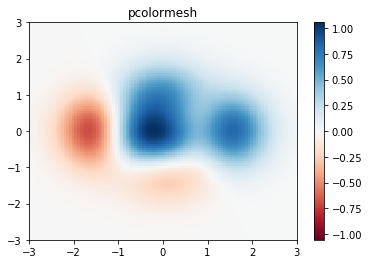

In [318]:
import matplotlib.pyplot as plt
import numpy as np

# generate 2 2d grids for the x & y bounds
# y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

# z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()